In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
train_ids = pd.read_csv('./fashion-mnist/train/train.csv')
test_ids = pd.read_csv('./fashion-mnist/test/test.csv')

In [3]:
train_ids.head()

,id,label
0,1,9
1,2,0
2,3,0
3,4,3
4,5,0


In [4]:
class GetData(Dataset):
    def __init__(self, type, root_dir='./') -> None:
        super(Dataset, self).__init__()
        self.type = type

        img_dir = os.path.join(root_dir, f'fashion-mnist/{str(type)}/{str(type)}')

        if os.path.isdir(img_dir):
            images = []

            if type == 'train':
                for id in train_ids['id']:
                    img_path = os.path.join(img_dir, f'{str(id)}.png')
                    img = imread(img_path, as_gray=True)
                    img = np.multiply(img, (1./255.))
                    img = img.astype('float32')
                    images.append(img)
                
                self.x = torch.tensor(images)
                self.y = F.one_hot(torch.tensor(train_ids['label'].values))

            if type == 'test':
                for id in test_ids['id']:
                    img_path = os.path.join(img_dir, f'{str(id)}.png')
                    img = imread(img_path, as_gray=True)
                    img = np.multiply(img, (1./255.))
                    img = img.astype('float32')
                    images.append(img)
                
                self.x = torch.tensor(images)


        else:
            raise OSError('parameter "type" must be either train or test')        
    
    def __getitem__(self, index):
        if self.type == 'train':
            return self.x[index], self.y[index]
        elif self.type == 'test': 
            return self.x[index]
        
    def __len__(self):
        return self.x.shape[0]

In [5]:
train_set = GetData('train')

C:\Users\ASC_Student\AppData\Local\Temp\ipykernel_15348\1640119489.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  self.x = torch.tensor(images)


In [6]:
train_set.x.shape

torch.Size([60000, 28, 28])

In [7]:
train_set.y.shape

torch.Size([60000, 10])

In [8]:
test_set = GetData('test')
test_set.x.shape

torch.Size([10000, 28, 28])

In [39]:
dl = DataLoader(train_set, batch_size=100)
print(f'Num data batches = {len(dl)}')
for x, y in dl:
    print(x.shape)
    print(y.shape)
    break

Num data batches = 600
torch.Size([100, 28, 28])
torch.Size([100, 10])


In [50]:
class ConvNet(nn.Sequential):
    def __init__(self) -> None:
        super(nn.Sequential, self).__init__()

        self.forward_pass = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=(3, 3), padding='same'), 
            nn.BatchNorm2d(4), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(4, 8, kernel_size=(3, 3), stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=(2, 2), stride=1),
            nn.Flatten(),
            nn.Linear(288, 144), 
            nn.ReLU(),
            nn.Linear(144, 100), 
            nn.ReLU(), 
            nn.Linear(100, 10), 
            # nn.Sigmoid()
        )
    
    def forward(self, x):
        batch_len = x.shape[0]
        x = x.view(batch_len, 1, 28, 28)        
        return self.forward_pass(x).squeeze()

In [46]:
net = ConvNet()

In [12]:
def plot_images(*images):
    fig, axs = plt.subplots(1, len(images))

    if len(images) != 1:
        for i in range(len(images)):
            axs[i].imshow(images[i])
            axs[i].grid(False)
            axs[i].axis('off')
    else:
        axs.imshow(images[0])
        axs.grid(False)
        axs.axis('off')

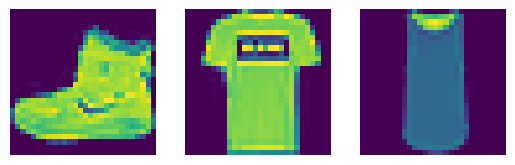

In [13]:
xs, ys = train_set[0:3]
test_imgs = xs.view(3, 1, 28, 28)
plot_images(test_imgs[0].squeeze(), test_imgs[1].squeeze(), test_imgs[2].squeeze())
# test_imgs[0].squeeze().shape

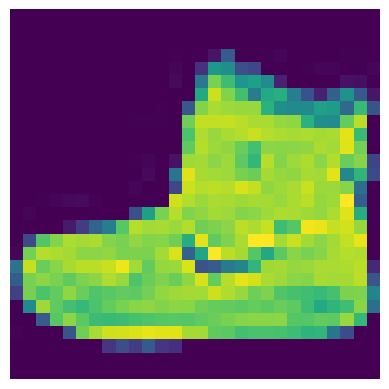

In [14]:
plot_images(train_set[0][0])

In [38]:
xs, ys = train_set[0:3]
net(xs)

tensor([[ 0.5378,  0.4118, -0.2655, -0.0423, -0.0287,  0.1891,  0.1121, -0.0783,
         -0.3018,  0.4760],
        [ 0.1242,  0.2448, -0.1255,  0.0533,  0.0196,  0.3164, -0.1036,  0.1687,
         -0.2496,  0.4083],
        [ 0.0687,  0.0294, -0.1384,  0.0679,  0.1507,  0.0101,  0.0835, -0.0373,
         -0.2127,  0.2279]], grad_fn=<SqueezeBackward0>)

In [19]:
xs.shape

torch.Size([3, 28, 28])

In [20]:
xs.shape[0]

3

In [40]:
loss = nn.CrossEntropyLoss()
loss(net(xs).float(), ys.float())

tensor(2.1726, grad_fn=<DivBackward1>)

In [41]:
def train(dl, network, epochs, learning_rate):
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    training_data = {"epochs": [], "losses": [], "epoch-loss": []}
    for epoch in range(epochs):
        num_batches = len(dl)

        curr_epoch_losses = []
        for j, (x, y) in enumerate(tqdm(dl)):
            optimizer.zero_grad()
            
            curr_loss = criterion(network(x).float(), y.float())            
            curr_loss.backward()
            optimizer.step()

            training_data["epochs"].append(epoch + (j / num_batches))
            training_data["losses"].append(curr_loss.item())
            curr_epoch_losses.append(curr_loss.item())

        training_data["epoch-loss"].append(np.mean(np.asarray(curr_epoch_losses)).item())

        print(f'Epoch #{(epoch + 1)}/{epochs} - Loss: {training_data["epoch-loss"][-1]}')
    
    return training_data

In [121]:
def plot_metrics(loss, epochs, num_epochs):
    # Averaging out the loss and accuracy to reduce noise in the graph
    avg_loss = np.mean(np.asarray(loss).reshape(num_epochs, -1))
    avg_epochs = np.mean(np.asarray(epochs).reshape(num_epochs, -1))

    plt.plot(avg_epochs, avg_loss)
    plt.xlabel('Epoch #')
    plt.ylabel('Cross Entropy Loss')
    plt.title('Loss per Epoch')
    plt.show()

In [51]:
net2 = ConvNet()

training_data = train(dl, net2, epochs=50, learning_rate=0.06)

100%|██████████| 600/600 [00:07<00:00, 83.17it/s]


Epoch #1/50 - Loss: 0.9523747599124909


100%|██████████| 600/600 [00:07<00:00, 79.21it/s]


Epoch #2/50 - Loss: 0.6602584139506023


100%|██████████| 600/600 [00:08<00:00, 73.72it/s]


Epoch #3/50 - Loss: 0.6148460641503334


100%|██████████| 600/600 [00:07<00:00, 75.48it/s]


Epoch #4/50 - Loss: 0.5985746728380521


100%|██████████| 600/600 [00:07<00:00, 75.75it/s]


Epoch #5/50 - Loss: 0.5861156004667282


100%|██████████| 600/600 [00:08<00:00, 73.28it/s]


Epoch #6/50 - Loss: 0.5690484748284022


100%|██████████| 600/600 [00:08<00:00, 73.71it/s]


Epoch #7/50 - Loss: 0.5756469431519509


100%|██████████| 600/600 [00:08<00:00, 75.00it/s]


Epoch #8/50 - Loss: 0.5647467192014058


100%|██████████| 600/600 [00:07<00:00, 75.34it/s]


Epoch #9/50 - Loss: 0.5607422911127409


100%|██████████| 600/600 [00:07<00:00, 76.08it/s]


Epoch #10/50 - Loss: 0.564620581716299


100%|██████████| 600/600 [00:07<00:00, 75.10it/s]


Epoch #11/50 - Loss: 0.5536645795901617


100%|██████████| 600/600 [00:07<00:00, 76.76it/s]


Epoch #12/50 - Loss: 0.5509145365655422


100%|██████████| 600/600 [00:07<00:00, 76.45it/s]


Epoch #13/50 - Loss: 0.560626548777024


100%|██████████| 600/600 [00:07<00:00, 78.00it/s]


Epoch #14/50 - Loss: 0.5452879789968331


100%|██████████| 600/600 [00:07<00:00, 76.37it/s]


Epoch #15/50 - Loss: 0.5659749598801136


100%|██████████| 600/600 [00:07<00:00, 77.20it/s]


Epoch #16/50 - Loss: 0.5520015811423461


100%|██████████| 600/600 [00:08<00:00, 73.55it/s]


Epoch #17/50 - Loss: 0.5478858268260955


100%|██████████| 600/600 [00:07<00:00, 76.94it/s]


Epoch #18/50 - Loss: 0.582371386786302


100%|██████████| 600/600 [00:08<00:00, 74.63it/s]


Epoch #19/50 - Loss: 0.5459074043234189


100%|██████████| 600/600 [00:08<00:00, 74.84it/s]


Epoch #20/50 - Loss: 0.5327651732663313


100%|██████████| 600/600 [00:09<00:00, 61.92it/s]


Epoch #21/50 - Loss: 0.55086275100708


100%|██████████| 600/600 [00:07<00:00, 77.35it/s]


Epoch #22/50 - Loss: 0.5627676853040854


100%|██████████| 600/600 [00:07<00:00, 76.15it/s]


Epoch #23/50 - Loss: 0.5427831868330638


100%|██████████| 600/600 [00:08<00:00, 74.89it/s]


Epoch #24/50 - Loss: 0.5427278402944405


100%|██████████| 600/600 [00:07<00:00, 76.35it/s]


Epoch #25/50 - Loss: 0.5398148732384046


100%|██████████| 600/600 [00:08<00:00, 72.55it/s]


Epoch #26/50 - Loss: 0.5401994713147481


100%|██████████| 600/600 [00:08<00:00, 70.20it/s]


Epoch #27/50 - Loss: 0.5341516010463238


100%|██████████| 600/600 [00:08<00:00, 74.05it/s]


Epoch #28/50 - Loss: 0.5663353932400544


100%|██████████| 600/600 [00:08<00:00, 73.00it/s]


Epoch #29/50 - Loss: 0.5510939103364945


100%|██████████| 600/600 [00:07<00:00, 75.80it/s]


Epoch #30/50 - Loss: 0.5457243821024895


100%|██████████| 600/600 [00:08<00:00, 75.00it/s]


Epoch #31/50 - Loss: 0.533285066485405


100%|██████████| 600/600 [00:08<00:00, 74.62it/s]


Epoch #32/50 - Loss: 0.5360441959400972


100%|██████████| 600/600 [00:07<00:00, 76.69it/s]


Epoch #33/50 - Loss: 0.5275244775911172


100%|██████████| 600/600 [00:07<00:00, 77.45it/s]


Epoch #34/50 - Loss: 0.5341549165050189


100%|██████████| 600/600 [00:07<00:00, 77.53it/s]


Epoch #35/50 - Loss: 0.5437618228793144


100%|██████████| 600/600 [00:07<00:00, 76.89it/s]


Epoch #36/50 - Loss: 0.5313231219351292


100%|██████████| 600/600 [00:08<00:00, 74.28it/s]


Epoch #37/50 - Loss: 0.5272314364711443


100%|██████████| 600/600 [00:08<00:00, 73.15it/s]


Epoch #38/50 - Loss: 0.5336835114657879


100%|██████████| 600/600 [00:07<00:00, 77.70it/s]


Epoch #39/50 - Loss: 0.5558003493150075


100%|██████████| 600/600 [00:07<00:00, 78.19it/s]


Epoch #40/50 - Loss: 0.5249985919892788


100%|██████████| 600/600 [00:07<00:00, 77.79it/s]


Epoch #41/50 - Loss: 0.5366857992112637


100%|██████████| 600/600 [00:10<00:00, 55.96it/s]


Epoch #42/50 - Loss: 0.523147984246413


100%|██████████| 600/600 [00:09<00:00, 63.46it/s]


Epoch #43/50 - Loss: 0.5416564926505089


100%|██████████| 600/600 [00:09<00:00, 60.79it/s]


Epoch #44/50 - Loss: 0.6536958624919256


100%|██████████| 600/600 [00:09<00:00, 63.23it/s]


Epoch #45/50 - Loss: 0.5429310083885988


100%|██████████| 600/600 [00:09<00:00, 61.48it/s]


Epoch #46/50 - Loss: 0.5478859195609888


100%|██████████| 600/600 [00:09<00:00, 64.50it/s]


Epoch #47/50 - Loss: 0.5333493345975876


100%|██████████| 600/600 [00:10<00:00, 57.53it/s]


Epoch #48/50 - Loss: 0.6244701022903124


100%|██████████| 600/600 [00:09<00:00, 61.40it/s]


Epoch #49/50 - Loss: 0.5320311341683069


100%|██████████| 600/600 [00:10<00:00, 59.39it/s]

Epoch #50/50 - Loss: 0.5237187224626542


In [124]:
def test(net):
    xs = test_set[::]

    correct = []
    incorrect = []

    fig, axs = plt.subplots(10, 4)

    img_types = {
        "0": "T-shirt",
        "1": "Trouser",
        "2": "Pullover",
        "3": "Dress",
        "4": "Coat",
        "5": "Sandal",
        "6": "Shirt",
        "7": "Sneaker",
        "8": "Bag",
        "9": "Shoe"
    }

    for i in range(40):
        # print(f'TEST #{i}: Predicted = {torch.argmax(net2(xs[i].unsqueeze(dim=0)))}; Actual = {plot_images(xs[i])}')
        axs[int(np.floor((i / 4.0)).item(0))][i % 4].imshow(xs[i])
        axs[int(np.floor((i / 4.0)).item(0))][i % 4].axis('off')
        axs[int(np.floor((i / 4.0)).item(0))][i % 4].grid(False)
        axs[int(np.floor((i / 4.0)).item(0))][i % 4].set_xlabel(img_types[str(torch.argmax(net2(xs[i].unsqueeze(dim=0))).item())], loc="center")

        print(f'Prediction for image ({int(np.floor((i / 4.0)).item(0)) + 1}, {(i % 4) + 1}) = {img_types[str(torch.argmax(net2(xs[i].unsqueeze(dim=0))).item())]}')

    plt.show()
        # axs[int(np.floor((i / 4.0)).item(0))][i % 4].set_xlabel("L Bozo")
        # print((int(np.floor((i / 4)).item(0))))

    # for i in range(len(test_set)):
    #     if torch.argmax(net2(xs[i].unsqueeze(dim=0))) == torch.argmax(ys[i]):
    #         correct += 1
    #     else:
    #         incorrect += 1

Prediction for image (1, 1) = Shoe
Prediction for image (1, 2) = Pullover
Prediction for image (1, 3) = Trouser
Prediction for image (1, 4) = Trouser
Prediction for image (2, 1) = Pullover
Prediction for image (2, 2) = Trouser
Prediction for image (2, 3) = Pullover
Prediction for image (2, 4) = Coat
Prediction for image (3, 1) = Sandal
Prediction for image (3, 2) = Sneaker
Prediction for image (3, 3) = Coat
Prediction for image (3, 4) = Sandal
Prediction for image (4, 1) = Sandal
Prediction for image (4, 2) = T-shirt
Prediction for image (4, 3) = Coat
Prediction for image (4, 4) = Trouser
Prediction for image (5, 1) = Coat
Prediction for image (5, 2) = Pullover
Prediction for image (5, 3) = Bag
Prediction for image (5, 4) = T-shirt
Prediction for image (6, 1) = Pullover
Prediction for image (6, 2) = Sandal
Prediction for image (6, 3) = Sneaker
Prediction for image (6, 4) = Sandal
Prediction for image (7, 1) = Trouser
Prediction for image (7, 2) = Pullover
Prediction for image (7, 3) = 

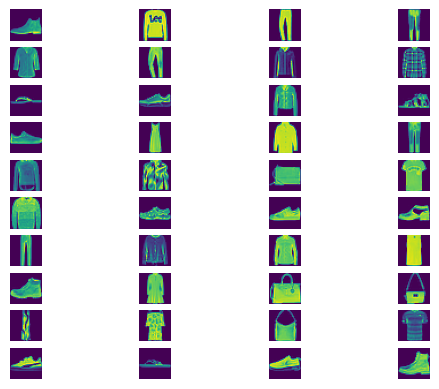

In [125]:
test(net2)